In [ ]:
"STFT-> SHORT TIME FOURIER TRANSFORM"

In [ ]:
import torch
import pandas as pd 
import numpy as np
import torch.nn as nn 

data_path = '/kaggle/input/environmental-sound-classification-50'

In [4]:
import os
os.listdir(data_path)

['audio', 'utils2.py', 'esc50.csv', 'bc_utils.py', 'utils.py']

In [5]:
data = pd.read_csv(os.path.join(data_path, 'esc50.csv')) 

In [6]:
data['category'].unique()

array(['dog', 'chirping_birds', 'vacuum_cleaner', 'thunderstorm',
       'door_wood_knock', 'can_opening', 'crow', 'clapping', 'fireworks',
       'chainsaw', 'airplane', 'mouse_click', 'pouring_water', 'train',
       'sheep', 'water_drops', 'church_bells', 'clock_alarm',
       'keyboard_typing', 'wind', 'footsteps', 'frog', 'cow',
       'brushing_teeth', 'car_horn', 'crackling_fire', 'helicopter',
       'drinking_sipping', 'rain', 'insects', 'laughing', 'hen', 'engine',
       'breathing', 'crying_baby', 'hand_saw', 'coughing',
       'glass_breaking', 'snoring', 'toilet_flush', 'pig',
       'washing_machine', 'clock_tick', 'sneezing', 'rooster',
       'sea_waves', 'siren', 'cat', 'door_wood_creaks', 'crickets'],
      dtype=object)

In [9]:
data['target'].unique()

array([ 0, 14, 36, 19, 30, 34,  9, 22, 48, 41, 47, 31, 17, 45,  8, 15, 46,
       37, 32, 16, 25,  4,  3, 27, 43, 12, 40, 29, 10,  7, 26,  6, 44, 23,
       20, 49, 24, 39, 28, 18,  2, 35, 38, 21,  1, 11, 42,  5, 33, 13])

In [10]:
data

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A


In [11]:
audio_path = "/kaggle/input/environmental-sound-classification-50/audio/audio"
all_audios = [file for file in os.listdir(audio_path) if '.wav' in file]

In [12]:
len(all_audios)

2000

In [13]:
# 50 classes each 40 audio files of length 3m20s
# total 2000 audios ^

In [14]:
import scipy
from scipy.io import wavfile

In [15]:
fs, aa = wavfile.read(os.path.join(audio_path, all_audios[0]))

In [16]:
print("Sampling rate:", fs)
print("Shape of data:", aa.shape)

Sampling rate: 44100
Shape of data: (220500,)


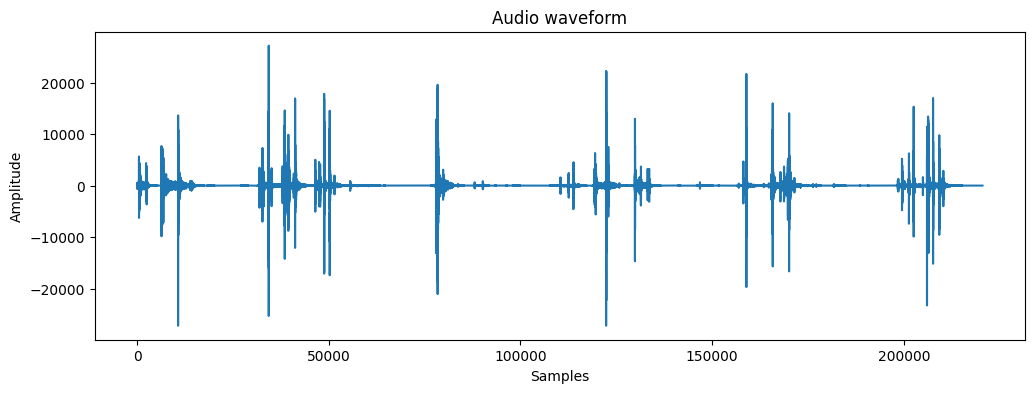

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(aa)
plt.title("Audio waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

In [18]:
from IPython.display import Audio
Audio(aa, rate=fs)

In [19]:
from scipy.signal import spectrogram

In [21]:
def get_spectrogram(signal, fs):
    f,t,Sxx = spectrogram(signal, fs=fs, nperseg=128, noverlap=64)
    Sxx = np.log1p(Sxx)
    return Sxx 

In [61]:
X, y = [], []
for audio in all_audios:
    audio_name = audio
    path = os.path.join(audio_path, audio)
    fs, signal = wavfile.read(path)
    specs= get_spectrogram(signal, fs=fs)
    ys = data.loc[data['filename']==audio_name, 'target'].values[0]
    X.append(specs)
    y.append(ys)
X = np.array(X)
y = np.array(y)

In [62]:
X = (X - X.mean()) / X.std()  # Standardize

In [63]:
shapes = [spec.shape for spec in X]
unique_shapes = set(shapes)
print(f"Unique shapes: {unique_shapes}")
print(f"Number of unique shapes: {len(unique_shapes)}")


Unique shapes: {(65, 3444)}
Number of unique shapes: 1


In [64]:
X.shape, y.shape

((2000, 65, 3444), (2000,))

In [65]:
X_tensor=torch.tensor(X, dtype=torch.float32).unsqueeze(1)
y_tensor = torch.tensor(y, dtype=torch.long)

In [66]:
class SpecCNN(nn.Module):
    def __init__(self, input_shape, num_classes):
        super(SpecCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), 
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        h, w=input_shape
        h, w = h//8, w//8

        
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(h*w*64, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

In [67]:
num_classes=50
input_shape = X_tensor.shape[2:]
model = SpecCNN(input_shape, num_classes).to('cuda')

In [68]:
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

In [75]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.1, random_state=42)

In [76]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)

In [77]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)
val_loader = DataLoader(val_dataset, batch_size=32)

In [78]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

In [79]:
import optuna

In [91]:
def training(model, train_loader, val_loader, epochs, lr):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    best_val_acc = 0

    for epoch in range(epochs):
        model.train()
        train_loss=0
        for x, y in train_loader:
            x, y = x.to('cuda'), y.to('cuda')
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss=0
        correct=0
        total=0
        with torch.no_grad():
            for x,y in val_loader:
                x, y = x.to('cuda'), y.to('cuda')
                out = model(x)
                loss = criterion(out, y)
                val_loss += loss.item()
                _, pred = torch.max(out, 1)
                total += y.size(0)
                correct += (pred==y).sum().item()
        val_loss /=len(val_loader)
        val_acc = 100 * correct/total
        
        print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/kaggle/working/Model/best_model.pth')
    return best_val_acc

In [97]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    batch_size = trial.suggest_categorical('batch_size', [16 ,32, 64])
    # dropout = trial.suggest_uniform('dropout', 0.2, 0.7)
    # hidden_size = trial.suggest_categorical('hidden_size', [64, 128, 256])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    model = SpecCNN(input_shape, num_classes).to('cuda')
    val_acc =training(model, train_loader, val_loader, epochs=20, lr=lr)
    return val_acc

In [98]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print(f"Best params: {study.best_params}")
print(f"Best validation accuracy: {study.best_value:.2f}%")

[I 2025-10-23 23:26:56,101] A new study created in memory with name: no-name-172ee33d-9f28-4e5a-a2ca-5b50a56cfc01
/tmp/ipykernel_37/205120826.py:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)


Epoch 1 | Train Loss: 3.8958 | Val Loss: 3.7829 | Val Acc: 5.00%
Epoch 2 | Train Loss: 3.7004 | Val Loss: 3.4791 | Val Acc: 15.00%
Epoch 3 | Train Loss: 3.4453 | Val Loss: 3.1745 | Val Acc: 18.33%
Epoch 4 | Train Loss: 3.1672 | Val Loss: 2.9099 | Val Acc: 25.00%
Epoch 5 | Train Loss: 2.7669 | Val Loss: 2.6016 | Val Acc: 30.00%
Epoch 6 | Train Loss: 2.3798 | Val Loss: 2.6114 | Val Acc: 35.00%
Epoch 7 | Train Loss: 1.9835 | Val Loss: 2.3054 | Val Acc: 33.33%
Epoch 8 | Train Loss: 1.7267 | Val Loss: 2.3850 | Val Acc: 36.67%
Epoch 9 | Train Loss: 1.4291 | Val Loss: 2.6062 | Val Acc: 33.33%
Epoch 10 | Train Loss: 1.2704 | Val Loss: 2.4180 | Val Acc: 30.00%
Epoch 11 | Train Loss: 1.1634 | Val Loss: 2.5053 | Val Acc: 33.33%
Epoch 12 | Train Loss: 0.9678 | Val Loss: 2.5628 | Val Acc: 35.00%
Epoch 13 | Train Loss: 0.9040 | Val Loss: 2.7947 | Val Acc: 36.67%
Epoch 14 | Train Loss: 0.8357 | Val Loss: 2.8946 | Val Acc: 30.00%
Epoch 15 | Train Loss: 0.7690 | Val Loss: 2.6790 | Val Acc: 35.00%
Epoch

[I 2025-10-23 23:28:54,114] Trial 0 finished with value: 45.0 and parameters: {'lr': 0.00030451606112170737, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 0.4738 | Val Loss: 3.1529 | Val Acc: 33.33%
Epoch 1 | Train Loss: 3.8929 | Val Loss: 3.8418 | Val Acc: 5.00%
Epoch 2 | Train Loss: 3.8082 | Val Loss: 3.7779 | Val Acc: 5.00%
Epoch 3 | Train Loss: 3.7552 | Val Loss: 3.7295 | Val Acc: 6.67%
Epoch 4 | Train Loss: 3.7240 | Val Loss: 3.6984 | Val Acc: 6.67%
Epoch 5 | Train Loss: 3.6829 | Val Loss: 3.6691 | Val Acc: 10.00%
Epoch 6 | Train Loss: 3.6573 | Val Loss: 3.6135 | Val Acc: 10.00%
Epoch 7 | Train Loss: 3.6009 | Val Loss: 3.5504 | Val Acc: 10.00%
Epoch 8 | Train Loss: 3.5588 | Val Loss: 3.5414 | Val Acc: 15.00%
Epoch 9 | Train Loss: 3.5029 | Val Loss: 3.5256 | Val Acc: 13.33%
Epoch 10 | Train Loss: 3.4722 | Val Loss: 3.4617 | Val Acc: 16.67%
Epoch 11 | Train Loss: 3.4641 | Val Loss: 3.4265 | Val Acc: 15.00%
Epoch 12 | Train Loss: 3.3862 | Val Loss: 3.3912 | Val Acc: 18.33%
Epoch 13 | Train Loss: 3.3466 | Val Loss: 3.3552 | Val Acc: 15.00%
Epoch 14 | Train Loss: 3.3461 | Val Loss: 3.3707 | Val Acc: 15.00%
Epoch 15

[I 2025-10-23 23:30:50,287] Trial 1 finished with value: 20.0 and parameters: {'lr': 1.798488980786814e-05, 'batch_size': 64}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 3.1290 | Val Loss: 3.2318 | Val Acc: 16.67%
Epoch 1 | Train Loss: 23.1079 | Val Loss: 3.9271 | Val Acc: 1.67%
Epoch 2 | Train Loss: 3.9148 | Val Loss: 3.9256 | Val Acc: 1.67%
Epoch 3 | Train Loss: 3.9136 | Val Loss: 3.9319 | Val Acc: 0.00%
Epoch 4 | Train Loss: 3.9131 | Val Loss: 3.9313 | Val Acc: 1.67%
Epoch 5 | Train Loss: 3.9124 | Val Loss: 3.9333 | Val Acc: 1.67%
Epoch 6 | Train Loss: 3.9121 | Val Loss: 3.9340 | Val Acc: 1.67%
Epoch 7 | Train Loss: 3.9119 | Val Loss: 3.9347 | Val Acc: 1.67%
Epoch 8 | Train Loss: 3.9123 | Val Loss: 3.9356 | Val Acc: 1.67%
Epoch 9 | Train Loss: 3.9129 | Val Loss: 3.9390 | Val Acc: 0.00%
Epoch 10 | Train Loss: 3.9128 | Val Loss: 3.9383 | Val Acc: 1.67%
Epoch 11 | Train Loss: 3.9114 | Val Loss: 3.9347 | Val Acc: 0.00%
Epoch 12 | Train Loss: 3.9121 | Val Loss: 3.9359 | Val Acc: 1.67%
Epoch 13 | Train Loss: 3.9130 | Val Loss: 3.9375 | Val Acc: 1.67%
Epoch 14 | Train Loss: 3.9124 | Val Loss: 3.9359 | Val Acc: 0.00%
Epoch 15 | Train 

[I 2025-10-23 23:32:36,135] Trial 2 finished with value: 1.6666666666666667 and parameters: {'lr': 0.009669436900108217, 'batch_size': 32}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 3.9124 | Val Loss: 3.9360 | Val Acc: 0.00%
Epoch 1 | Train Loss: 4.0811 | Val Loss: 3.8864 | Val Acc: 5.00%
Epoch 2 | Train Loss: 3.8457 | Val Loss: 3.7708 | Val Acc: 6.67%
Epoch 3 | Train Loss: 3.7460 | Val Loss: 3.6744 | Val Acc: 10.00%
Epoch 4 | Train Loss: 3.6174 | Val Loss: 3.5607 | Val Acc: 11.67%
Epoch 5 | Train Loss: 3.5187 | Val Loss: 3.4591 | Val Acc: 8.33%
Epoch 6 | Train Loss: 3.3523 | Val Loss: 3.3136 | Val Acc: 10.00%
Epoch 7 | Train Loss: 3.2086 | Val Loss: 3.2693 | Val Acc: 16.67%
Epoch 8 | Train Loss: 3.0497 | Val Loss: 3.1117 | Val Acc: 20.00%
Epoch 9 | Train Loss: 2.9154 | Val Loss: 3.1039 | Val Acc: 25.00%
Epoch 10 | Train Loss: 2.7499 | Val Loss: 2.9759 | Val Acc: 26.67%
Epoch 11 | Train Loss: 2.5727 | Val Loss: 2.9249 | Val Acc: 28.33%
Epoch 12 | Train Loss: 2.4108 | Val Loss: 2.8575 | Val Acc: 28.33%
Epoch 13 | Train Loss: 2.2232 | Val Loss: 2.7344 | Val Acc: 35.00%
Epoch 14 | Train Loss: 2.1167 | Val Loss: 2.8130 | Val Acc: 30.00%
Epoch 15

[I 2025-10-23 23:34:24,039] Trial 3 finished with value: 35.0 and parameters: {'lr': 0.0002776772847335551, 'batch_size': 64}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.4307 | Val Loss: 2.9373 | Val Acc: 33.33%
Epoch 1 | Train Loss: 4.0209 | Val Loss: 3.8417 | Val Acc: 3.33%
Epoch 2 | Train Loss: 3.6197 | Val Loss: 3.5180 | Val Acc: 11.67%
Epoch 3 | Train Loss: 3.2874 | Val Loss: 3.0119 | Val Acc: 20.00%
Epoch 4 | Train Loss: 2.9811 | Val Loss: 2.9057 | Val Acc: 28.33%
Epoch 5 | Train Loss: 2.6128 | Val Loss: 2.5791 | Val Acc: 31.67%
Epoch 6 | Train Loss: 2.2568 | Val Loss: 2.3749 | Val Acc: 25.00%
Epoch 7 | Train Loss: 2.0788 | Val Loss: 2.6199 | Val Acc: 31.67%
Epoch 8 | Train Loss: 1.8485 | Val Loss: 3.0517 | Val Acc: 31.67%
Epoch 9 | Train Loss: 1.5271 | Val Loss: 3.1112 | Val Acc: 33.33%
Epoch 10 | Train Loss: 1.4459 | Val Loss: 2.8090 | Val Acc: 36.67%
Epoch 11 | Train Loss: 1.2417 | Val Loss: 3.0168 | Val Acc: 30.00%
Epoch 12 | Train Loss: 1.0990 | Val Loss: 3.0506 | Val Acc: 33.33%
Epoch 13 | Train Loss: 1.0374 | Val Loss: 2.9578 | Val Acc: 33.33%
Epoch 14 | Train Loss: 0.9290 | Val Loss: 3.0031 | Val Acc: 28.33%
Epoch

[I 2025-10-23 23:36:20,198] Trial 4 finished with value: 36.666666666666664 and parameters: {'lr': 0.001103334820733431, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 0.6564 | Val Loss: 3.3971 | Val Acc: 31.67%
Epoch 1 | Train Loss: 3.9091 | Val Loss: 3.8376 | Val Acc: 11.67%
Epoch 2 | Train Loss: 3.8341 | Val Loss: 3.8003 | Val Acc: 6.67%
Epoch 3 | Train Loss: 3.7989 | Val Loss: 3.7407 | Val Acc: 8.33%
Epoch 4 | Train Loss: 3.7753 | Val Loss: 3.7156 | Val Acc: 6.67%
Epoch 5 | Train Loss: 3.7357 | Val Loss: 3.6701 | Val Acc: 13.33%
Epoch 6 | Train Loss: 3.6914 | Val Loss: 3.6351 | Val Acc: 11.67%
Epoch 7 | Train Loss: 3.6822 | Val Loss: 3.5848 | Val Acc: 16.67%
Epoch 8 | Train Loss: 3.6389 | Val Loss: 3.5479 | Val Acc: 11.67%
Epoch 9 | Train Loss: 3.6313 | Val Loss: 3.5520 | Val Acc: 13.33%
Epoch 10 | Train Loss: 3.5861 | Val Loss: 3.5012 | Val Acc: 15.00%
Epoch 11 | Train Loss: 3.5518 | Val Loss: 3.4669 | Val Acc: 20.00%
Epoch 12 | Train Loss: 3.5464 | Val Loss: 3.4571 | Val Acc: 18.33%
Epoch 13 | Train Loss: 3.5170 | Val Loss: 3.4444 | Val Acc: 20.00%
Epoch 14 | Train Loss: 3.4690 | Val Loss: 3.3747 | Val Acc: 15.00%
Epoch 1

[I 2025-10-23 23:38:07,075] Trial 5 finished with value: 23.333333333333332 and parameters: {'lr': 1.666052121553197e-05, 'batch_size': 64}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 3.3381 | Val Loss: 3.2862 | Val Acc: 15.00%
Epoch 1 | Train Loss: 3.8956 | Val Loss: 3.8340 | Val Acc: 3.33%
Epoch 2 | Train Loss: 3.7976 | Val Loss: 3.7344 | Val Acc: 8.33%
Epoch 3 | Train Loss: 3.7404 | Val Loss: 3.7118 | Val Acc: 10.00%
Epoch 4 | Train Loss: 3.6857 | Val Loss: 3.5958 | Val Acc: 8.33%
Epoch 5 | Train Loss: 3.5838 | Val Loss: 3.5039 | Val Acc: 13.33%
Epoch 6 | Train Loss: 3.5080 | Val Loss: 3.4807 | Val Acc: 15.00%
Epoch 7 | Train Loss: 3.4753 | Val Loss: 3.4006 | Val Acc: 18.33%
Epoch 8 | Train Loss: 3.3578 | Val Loss: 3.3549 | Val Acc: 23.33%
Epoch 9 | Train Loss: 3.3138 | Val Loss: 3.2874 | Val Acc: 23.33%
Epoch 10 | Train Loss: 3.2257 | Val Loss: 3.2684 | Val Acc: 21.67%
Epoch 11 | Train Loss: 3.1341 | Val Loss: 3.2612 | Val Acc: 20.00%
Epoch 12 | Train Loss: 3.0160 | Val Loss: 3.2554 | Val Acc: 15.00%
Epoch 13 | Train Loss: 2.9630 | Val Loss: 3.1495 | Val Acc: 16.67%
Epoch 14 | Train Loss: 2.8583 | Val Loss: 3.1159 | Val Acc: 18.33%
Epoch 1

[I 2025-10-23 23:39:57,370] Trial 6 finished with value: 30.0 and parameters: {'lr': 6.58518301134512e-05, 'batch_size': 32}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 2.3937 | Val Loss: 2.9698 | Val Acc: 20.00%
Epoch 1 | Train Loss: 4.9508 | Val Loss: 3.8876 | Val Acc: 1.67%
Epoch 2 | Train Loss: 3.8398 | Val Loss: 3.8015 | Val Acc: 1.67%
Epoch 3 | Train Loss: 3.7107 | Val Loss: 3.5909 | Val Acc: 11.67%
Epoch 4 | Train Loss: 3.5733 | Val Loss: 3.4856 | Val Acc: 5.00%
Epoch 5 | Train Loss: 3.3879 | Val Loss: 3.3190 | Val Acc: 15.00%
Epoch 6 | Train Loss: 3.2645 | Val Loss: 3.2777 | Val Acc: 13.33%
Epoch 7 | Train Loss: 3.0010 | Val Loss: 3.0830 | Val Acc: 16.67%
Epoch 8 | Train Loss: 2.8250 | Val Loss: 2.9499 | Val Acc: 16.67%
Epoch 9 | Train Loss: 2.5682 | Val Loss: 2.9137 | Val Acc: 25.00%
Epoch 10 | Train Loss: 2.3196 | Val Loss: 2.7685 | Val Acc: 26.67%
Epoch 11 | Train Loss: 2.1558 | Val Loss: 2.7637 | Val Acc: 23.33%
Epoch 12 | Train Loss: 2.0790 | Val Loss: 2.9675 | Val Acc: 21.67%
Epoch 13 | Train Loss: 1.8918 | Val Loss: 2.8177 | Val Acc: 26.67%
Epoch 14 | Train Loss: 1.6732 | Val Loss: 2.8156 | Val Acc: 28.33%
Epoch 1

[I 2025-10-23 23:41:43,466] Trial 7 finished with value: 31.666666666666668 and parameters: {'lr': 0.0006899910870606182, 'batch_size': 64}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.1176 | Val Loss: 3.2010 | Val Acc: 26.67%
Epoch 1 | Train Loss: 3.9079 | Val Loss: 3.8203 | Val Acc: 3.33%
Epoch 2 | Train Loss: 3.8009 | Val Loss: 3.7545 | Val Acc: 5.00%
Epoch 3 | Train Loss: 3.7006 | Val Loss: 3.6472 | Val Acc: 6.67%
Epoch 4 | Train Loss: 3.5776 | Val Loss: 3.4672 | Val Acc: 5.00%
Epoch 5 | Train Loss: 3.4164 | Val Loss: 3.3304 | Val Acc: 18.33%
Epoch 6 | Train Loss: 3.2600 | Val Loss: 3.2423 | Val Acc: 15.00%
Epoch 7 | Train Loss: 3.0774 | Val Loss: 3.0564 | Val Acc: 20.00%
Epoch 8 | Train Loss: 2.8999 | Val Loss: 3.0152 | Val Acc: 20.00%
Epoch 9 | Train Loss: 2.7102 | Val Loss: 2.9781 | Val Acc: 18.33%
Epoch 10 | Train Loss: 2.5444 | Val Loss: 2.8839 | Val Acc: 23.33%
Epoch 11 | Train Loss: 2.3426 | Val Loss: 2.7675 | Val Acc: 28.33%
Epoch 12 | Train Loss: 2.1983 | Val Loss: 2.8420 | Val Acc: 23.33%
Epoch 13 | Train Loss: 2.0297 | Val Loss: 2.8673 | Val Acc: 18.33%
Epoch 14 | Train Loss: 1.9313 | Val Loss: 2.8290 | Val Acc: 25.00%
Epoch 15

[I 2025-10-23 23:43:33,428] Trial 8 finished with value: 31.666666666666668 and parameters: {'lr': 0.0001517885164992939, 'batch_size': 32}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.2921 | Val Loss: 3.0227 | Val Acc: 25.00%
Epoch 1 | Train Loss: 5.1108 | Val Loss: 3.9073 | Val Acc: 1.67%
Epoch 2 | Train Loss: 3.9136 | Val Loss: 3.9104 | Val Acc: 1.67%
Epoch 3 | Train Loss: 3.9131 | Val Loss: 3.9119 | Val Acc: 1.67%
Epoch 4 | Train Loss: 3.9123 | Val Loss: 3.9136 | Val Acc: 1.67%
Epoch 5 | Train Loss: 3.9120 | Val Loss: 3.9154 | Val Acc: 1.67%
Epoch 6 | Train Loss: 3.9117 | Val Loss: 3.9167 | Val Acc: 1.67%
Epoch 7 | Train Loss: 3.9112 | Val Loss: 3.9179 | Val Acc: 1.67%
Epoch 8 | Train Loss: 3.9107 | Val Loss: 3.9193 | Val Acc: 1.67%
Epoch 9 | Train Loss: 3.9104 | Val Loss: 3.9219 | Val Acc: 1.67%
Epoch 10 | Train Loss: 3.9105 | Val Loss: 3.9229 | Val Acc: 1.67%
Epoch 11 | Train Loss: 3.9105 | Val Loss: 3.9251 | Val Acc: 1.67%
Epoch 12 | Train Loss: 3.9099 | Val Loss: 3.9239 | Val Acc: 1.67%
Epoch 13 | Train Loss: 3.9097 | Val Loss: 3.9255 | Val Acc: 1.67%
Epoch 14 | Train Loss: 3.9095 | Val Loss: 3.9274 | Val Acc: 1.67%
Epoch 15 | Train L

[I 2025-10-23 23:45:15,727] Trial 9 finished with value: 1.6666666666666667 and parameters: {'lr': 0.0027349734480352564, 'batch_size': 64}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 3.9094 | Val Loss: 3.9311 | Val Acc: 1.67%
Epoch 1 | Train Loss: 3.8992 | Val Loss: 3.8216 | Val Acc: 0.00%
Epoch 2 | Train Loss: 3.7755 | Val Loss: 3.6940 | Val Acc: 5.00%
Epoch 3 | Train Loss: 3.6747 | Val Loss: 3.5487 | Val Acc: 6.67%
Epoch 4 | Train Loss: 3.5376 | Val Loss: 3.4686 | Val Acc: 8.33%
Epoch 5 | Train Loss: 3.4296 | Val Loss: 3.4224 | Val Acc: 13.33%
Epoch 6 | Train Loss: 3.3100 | Val Loss: 3.2881 | Val Acc: 18.33%
Epoch 7 | Train Loss: 3.1587 | Val Loss: 3.1090 | Val Acc: 15.00%
Epoch 8 | Train Loss: 3.0163 | Val Loss: 3.1164 | Val Acc: 18.33%
Epoch 9 | Train Loss: 2.8717 | Val Loss: 3.0574 | Val Acc: 20.00%
Epoch 10 | Train Loss: 2.7484 | Val Loss: 3.0597 | Val Acc: 20.00%
Epoch 11 | Train Loss: 2.5923 | Val Loss: 2.9362 | Val Acc: 25.00%
Epoch 12 | Train Loss: 2.4648 | Val Loss: 2.9331 | Val Acc: 25.00%
Epoch 13 | Train Loss: 2.3688 | Val Loss: 2.8838 | Val Acc: 25.00%
Epoch 14 | Train Loss: 2.1799 | Val Loss: 2.8292 | Val Acc: 28.33%
Epoch 15 

[I 2025-10-23 23:47:14,000] Trial 10 finished with value: 31.666666666666668 and parameters: {'lr': 7.583474965725945e-05, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.6550 | Val Loss: 2.8410 | Val Acc: 21.67%
Epoch 1 | Train Loss: 3.9952 | Val Loss: 3.7283 | Val Acc: 3.33%
Epoch 2 | Train Loss: 3.6340 | Val Loss: 3.3652 | Val Acc: 18.33%
Epoch 3 | Train Loss: 3.3347 | Val Loss: 3.1318 | Val Acc: 16.67%
Epoch 4 | Train Loss: 3.0956 | Val Loss: 3.0042 | Val Acc: 21.67%
Epoch 5 | Train Loss: 2.8989 | Val Loss: 2.9307 | Val Acc: 21.67%
Epoch 6 | Train Loss: 2.6882 | Val Loss: 2.8440 | Val Acc: 18.33%
Epoch 7 | Train Loss: 2.5273 | Val Loss: 2.5749 | Val Acc: 31.67%
Epoch 8 | Train Loss: 2.2210 | Val Loss: 2.6275 | Val Acc: 23.33%
Epoch 9 | Train Loss: 1.9023 | Val Loss: 2.5900 | Val Acc: 31.67%
Epoch 10 | Train Loss: 1.6922 | Val Loss: 2.5403 | Val Acc: 35.00%
Epoch 11 | Train Loss: 1.4307 | Val Loss: 2.8489 | Val Acc: 31.67%
Epoch 12 | Train Loss: 1.3525 | Val Loss: 2.6449 | Val Acc: 33.33%
Epoch 13 | Train Loss: 1.2150 | Val Loss: 2.8421 | Val Acc: 26.67%
Epoch 14 | Train Loss: 1.1159 | Val Loss: 2.8839 | Val Acc: 38.33%
Epoch

[I 2025-10-23 23:49:09,989] Trial 11 finished with value: 38.333333333333336 and parameters: {'lr': 0.0008836440648788342, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 0.7101 | Val Loss: 3.6346 | Val Acc: 31.67%
Epoch 1 | Train Loss: 4.1081 | Val Loss: 3.7652 | Val Acc: 8.33%
Epoch 2 | Train Loss: 3.5980 | Val Loss: 3.2975 | Val Acc: 20.00%
Epoch 3 | Train Loss: 3.3093 | Val Loss: 3.0136 | Val Acc: 18.33%
Epoch 4 | Train Loss: 2.9812 | Val Loss: 3.0608 | Val Acc: 26.67%
Epoch 5 | Train Loss: 2.7062 | Val Loss: 2.7980 | Val Acc: 15.00%
Epoch 6 | Train Loss: 2.2853 | Val Loss: 2.6955 | Val Acc: 26.67%
Epoch 7 | Train Loss: 1.9909 | Val Loss: 2.8241 | Val Acc: 28.33%
Epoch 8 | Train Loss: 1.7913 | Val Loss: 2.7416 | Val Acc: 30.00%
Epoch 9 | Train Loss: 1.5155 | Val Loss: 2.6815 | Val Acc: 33.33%
Epoch 10 | Train Loss: 1.4177 | Val Loss: 2.7353 | Val Acc: 31.67%
Epoch 11 | Train Loss: 1.2500 | Val Loss: 3.0052 | Val Acc: 28.33%
Epoch 12 | Train Loss: 1.1304 | Val Loss: 3.1341 | Val Acc: 25.00%
Epoch 13 | Train Loss: 1.0189 | Val Loss: 3.3441 | Val Acc: 21.67%
Epoch 14 | Train Loss: 0.9184 | Val Loss: 3.2284 | Val Acc: 21.67%
Epoch

[I 2025-10-23 23:51:05,801] Trial 12 finished with value: 33.333333333333336 and parameters: {'lr': 0.0010749489018748153, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 0.6611 | Val Loss: 4.0267 | Val Acc: 18.33%
Epoch 1 | Train Loss: 4.5042 | Val Loss: 3.9221 | Val Acc: 1.67%
Epoch 2 | Train Loss: 3.9140 | Val Loss: 3.9236 | Val Acc: 1.67%
Epoch 3 | Train Loss: 3.9130 | Val Loss: 3.9257 | Val Acc: 1.67%
Epoch 4 | Train Loss: 3.9131 | Val Loss: 3.9274 | Val Acc: 1.67%
Epoch 5 | Train Loss: 3.9116 | Val Loss: 3.9283 | Val Acc: 1.67%
Epoch 6 | Train Loss: 3.9111 | Val Loss: 3.9303 | Val Acc: 1.67%
Epoch 7 | Train Loss: 3.9113 | Val Loss: 3.9321 | Val Acc: 1.67%
Epoch 8 | Train Loss: 3.9120 | Val Loss: 3.9324 | Val Acc: 0.00%
Epoch 9 | Train Loss: 3.9179 | Val Loss: 3.9302 | Val Acc: 1.67%
Epoch 10 | Train Loss: 3.9112 | Val Loss: 3.9332 | Val Acc: 1.67%
Epoch 11 | Train Loss: 3.9113 | Val Loss: 3.9333 | Val Acc: 1.67%
Epoch 12 | Train Loss: 3.9106 | Val Loss: 3.9354 | Val Acc: 0.00%
Epoch 13 | Train Loss: 3.9108 | Val Loss: 3.9360 | Val Acc: 1.67%
Epoch 14 | Train Loss: 3.9107 | Val Loss: 3.9355 | Val Acc: 1.67%
Epoch 15 | Train L

[I 2025-10-23 23:52:59,940] Trial 13 finished with value: 1.6666666666666667 and parameters: {'lr': 0.0030881435821477365, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 3.9103 | Val Loss: 3.9360 | Val Acc: 1.67%
Epoch 1 | Train Loss: 4.0123 | Val Loss: 3.7493 | Val Acc: 3.33%
Epoch 2 | Train Loss: 3.7682 | Val Loss: 3.6242 | Val Acc: 5.00%
Epoch 3 | Train Loss: 3.6436 | Val Loss: 3.5082 | Val Acc: 15.00%
Epoch 4 | Train Loss: 3.4779 | Val Loss: 3.3145 | Val Acc: 16.67%
Epoch 5 | Train Loss: 3.3135 | Val Loss: 3.2648 | Val Acc: 13.33%
Epoch 6 | Train Loss: 3.1597 | Val Loss: 3.0064 | Val Acc: 20.00%
Epoch 7 | Train Loss: 2.8474 | Val Loss: 2.8925 | Val Acc: 30.00%
Epoch 8 | Train Loss: 2.5921 | Val Loss: 2.7068 | Val Acc: 31.67%
Epoch 9 | Train Loss: 2.4289 | Val Loss: 2.5965 | Val Acc: 30.00%
Epoch 10 | Train Loss: 2.2156 | Val Loss: 2.5870 | Val Acc: 25.00%
Epoch 11 | Train Loss: 2.0231 | Val Loss: 2.6087 | Val Acc: 31.67%
Epoch 12 | Train Loss: 1.9097 | Val Loss: 2.5752 | Val Acc: 33.33%
Epoch 13 | Train Loss: 1.7851 | Val Loss: 2.5771 | Val Acc: 33.33%
Epoch 14 | Train Loss: 1.7099 | Val Loss: 2.5427 | Val Acc: 36.67%
Epoch 1

[I 2025-10-23 23:54:58,062] Trial 14 finished with value: 40.0 and parameters: {'lr': 0.00038651314021878326, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.2932 | Val Loss: 2.9248 | Val Acc: 36.67%
Epoch 1 | Train Loss: 4.0023 | Val Loss: 3.8325 | Val Acc: 6.67%
Epoch 2 | Train Loss: 3.7732 | Val Loss: 3.6446 | Val Acc: 5.00%
Epoch 3 | Train Loss: 3.5886 | Val Loss: 3.4050 | Val Acc: 10.00%
Epoch 4 | Train Loss: 3.4021 | Val Loss: 3.1694 | Val Acc: 11.67%
Epoch 5 | Train Loss: 3.2044 | Val Loss: 3.1368 | Val Acc: 16.67%
Epoch 6 | Train Loss: 2.9794 | Val Loss: 2.9676 | Val Acc: 26.67%
Epoch 7 | Train Loss: 2.7964 | Val Loss: 2.9725 | Val Acc: 21.67%
Epoch 8 | Train Loss: 2.5356 | Val Loss: 2.8344 | Val Acc: 28.33%
Epoch 9 | Train Loss: 2.3871 | Val Loss: 2.8634 | Val Acc: 23.33%
Epoch 10 | Train Loss: 2.2100 | Val Loss: 2.9376 | Val Acc: 28.33%
Epoch 11 | Train Loss: 2.1264 | Val Loss: 3.1137 | Val Acc: 30.00%
Epoch 12 | Train Loss: 1.9509 | Val Loss: 3.0063 | Val Acc: 30.00%
Epoch 13 | Train Loss: 1.9001 | Val Loss: 2.8436 | Val Acc: 33.33%
Epoch 14 | Train Loss: 1.8087 | Val Loss: 2.8376 | Val Acc: 31.67%
Epoch 

[I 2025-10-23 23:56:56,109] Trial 15 finished with value: 33.333333333333336 and parameters: {'lr': 0.0003006580357025381, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.2822 | Val Loss: 3.0213 | Val Acc: 31.67%
Epoch 1 | Train Loss: 3.8805 | Val Loss: 3.8118 | Val Acc: 3.33%
Epoch 2 | Train Loss: 3.7441 | Val Loss: 3.7427 | Val Acc: 6.67%
Epoch 3 | Train Loss: 3.6203 | Val Loss: 3.5886 | Val Acc: 8.33%
Epoch 4 | Train Loss: 3.4938 | Val Loss: 3.4168 | Val Acc: 10.00%
Epoch 5 | Train Loss: 3.3088 | Val Loss: 3.2910 | Val Acc: 16.67%
Epoch 6 | Train Loss: 3.1792 | Val Loss: 3.2142 | Val Acc: 16.67%
Epoch 7 | Train Loss: 3.0160 | Val Loss: 3.0816 | Val Acc: 20.00%
Epoch 8 | Train Loss: 2.8382 | Val Loss: 3.0122 | Val Acc: 15.00%
Epoch 9 | Train Loss: 2.5686 | Val Loss: 2.9074 | Val Acc: 18.33%
Epoch 10 | Train Loss: 2.4396 | Val Loss: 2.8230 | Val Acc: 18.33%
Epoch 11 | Train Loss: 2.2396 | Val Loss: 2.9073 | Val Acc: 13.33%
Epoch 12 | Train Loss: 2.0977 | Val Loss: 2.7907 | Val Acc: 16.67%
Epoch 13 | Train Loss: 1.9128 | Val Loss: 2.7440 | Val Acc: 21.67%
Epoch 14 | Train Loss: 1.7782 | Val Loss: 2.5866 | Val Acc: 20.00%
Epoch 1

[I 2025-10-23 23:58:54,617] Trial 16 finished with value: 30.0 and parameters: {'lr': 8.862726681183703e-05, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.2212 | Val Loss: 2.6502 | Val Acc: 26.67%
Epoch 1 | Train Loss: 3.9120 | Val Loss: 3.8041 | Val Acc: 8.33%
Epoch 2 | Train Loss: 3.8141 | Val Loss: 3.7373 | Val Acc: 6.67%
Epoch 3 | Train Loss: 3.7515 | Val Loss: 3.6377 | Val Acc: 10.00%
Epoch 4 | Train Loss: 3.6812 | Val Loss: 3.5899 | Val Acc: 10.00%
Epoch 5 | Train Loss: 3.5993 | Val Loss: 3.5154 | Val Acc: 11.67%
Epoch 6 | Train Loss: 3.5346 | Val Loss: 3.4118 | Val Acc: 10.00%
Epoch 7 | Train Loss: 3.4722 | Val Loss: 3.3175 | Val Acc: 18.33%
Epoch 8 | Train Loss: 3.3903 | Val Loss: 3.2507 | Val Acc: 15.00%
Epoch 9 | Train Loss: 3.3561 | Val Loss: 3.2403 | Val Acc: 16.67%
Epoch 10 | Train Loss: 3.2874 | Val Loss: 3.1918 | Val Acc: 21.67%
Epoch 11 | Train Loss: 3.2227 | Val Loss: 3.0467 | Val Acc: 18.33%
Epoch 12 | Train Loss: 3.1730 | Val Loss: 3.0429 | Val Acc: 25.00%
Epoch 13 | Train Loss: 3.1006 | Val Loss: 3.0452 | Val Acc: 18.33%
Epoch 14 | Train Loss: 3.0931 | Val Loss: 3.0364 | Val Acc: 20.00%
Epoch 

[I 2025-10-24 00:00:53,181] Trial 17 finished with value: 26.666666666666668 and parameters: {'lr': 4.248525997555676e-05, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 2.6717 | Val Loss: 2.8700 | Val Acc: 20.00%
Epoch 1 | Train Loss: 3.9762 | Val Loss: 3.8201 | Val Acc: 3.33%
Epoch 2 | Train Loss: 3.7892 | Val Loss: 3.5669 | Val Acc: 5.00%
Epoch 3 | Train Loss: 3.5457 | Val Loss: 3.2778 | Val Acc: 8.33%
Epoch 4 | Train Loss: 3.2384 | Val Loss: 3.1291 | Val Acc: 16.67%
Epoch 5 | Train Loss: 2.9544 | Val Loss: 3.0233 | Val Acc: 15.00%
Epoch 6 | Train Loss: 2.6392 | Val Loss: 2.9507 | Val Acc: 25.00%
Epoch 7 | Train Loss: 2.4687 | Val Loss: 2.9880 | Val Acc: 26.67%
Epoch 8 | Train Loss: 2.3056 | Val Loss: 2.9894 | Val Acc: 28.33%
Epoch 9 | Train Loss: 2.1031 | Val Loss: 3.2093 | Val Acc: 20.00%
Epoch 10 | Train Loss: 1.9183 | Val Loss: 2.9774 | Val Acc: 28.33%
Epoch 11 | Train Loss: 1.7358 | Val Loss: 3.1178 | Val Acc: 30.00%
Epoch 12 | Train Loss: 1.6374 | Val Loss: 3.3031 | Val Acc: 26.67%
Epoch 13 | Train Loss: 1.5464 | Val Loss: 3.2941 | Val Acc: 25.00%
Epoch 14 | Train Loss: 1.4494 | Val Loss: 3.2944 | Val Acc: 30.00%
Epoch 1

[I 2025-10-24 00:02:50,868] Trial 18 finished with value: 30.0 and parameters: {'lr': 0.0005026855152849178, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.1309 | Val Loss: 3.5199 | Val Acc: 28.33%
Epoch 1 | Train Loss: 3.9078 | Val Loss: 3.8259 | Val Acc: 10.00%
Epoch 2 | Train Loss: 3.7850 | Val Loss: 3.7358 | Val Acc: 10.00%
Epoch 3 | Train Loss: 3.6217 | Val Loss: 3.5607 | Val Acc: 15.00%
Epoch 4 | Train Loss: 3.4597 | Val Loss: 3.4064 | Val Acc: 20.00%
Epoch 5 | Train Loss: 3.2694 | Val Loss: 3.2559 | Val Acc: 18.33%
Epoch 6 | Train Loss: 3.0431 | Val Loss: 3.1550 | Val Acc: 16.67%
Epoch 7 | Train Loss: 2.8626 | Val Loss: 3.0356 | Val Acc: 16.67%
Epoch 8 | Train Loss: 2.6589 | Val Loss: 2.9442 | Val Acc: 25.00%
Epoch 9 | Train Loss: 2.3658 | Val Loss: 2.9379 | Val Acc: 23.33%
Epoch 10 | Train Loss: 2.1513 | Val Loss: 2.7944 | Val Acc: 25.00%
Epoch 11 | Train Loss: 2.0092 | Val Loss: 2.7461 | Val Acc: 30.00%
Epoch 12 | Train Loss: 1.7225 | Val Loss: 2.7992 | Val Acc: 30.00%
Epoch 13 | Train Loss: 1.6516 | Val Loss: 2.7001 | Val Acc: 28.33%
Epoch 14 | Train Loss: 1.4821 | Val Loss: 2.9530 | Val Acc: 30.00%
Epoc

[I 2025-10-24 00:04:48,784] Trial 19 finished with value: 35.0 and parameters: {'lr': 0.0001721902841951261, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.0451 | Val Loss: 3.1334 | Val Acc: 30.00%
Epoch 1 | Train Loss: 4.6100 | Val Loss: 3.9154 | Val Acc: 1.67%
Epoch 2 | Train Loss: 3.8890 | Val Loss: 3.8676 | Val Acc: 1.67%
Epoch 3 | Train Loss: 3.6740 | Val Loss: 3.7032 | Val Acc: 3.33%
Epoch 4 | Train Loss: 3.2407 | Val Loss: 3.5600 | Val Acc: 10.00%
Epoch 5 | Train Loss: 2.7607 | Val Loss: 3.6482 | Val Acc: 8.33%
Epoch 6 | Train Loss: 2.3442 | Val Loss: 3.6916 | Val Acc: 18.33%
Epoch 7 | Train Loss: 2.0010 | Val Loss: 4.4192 | Val Acc: 15.00%
Epoch 8 | Train Loss: 1.6515 | Val Loss: 4.5344 | Val Acc: 16.67%
Epoch 9 | Train Loss: 1.3823 | Val Loss: 5.0793 | Val Acc: 11.67%
Epoch 10 | Train Loss: 1.1469 | Val Loss: 5.0085 | Val Acc: 15.00%
Epoch 11 | Train Loss: 1.1390 | Val Loss: 4.9398 | Val Acc: 13.33%
Epoch 12 | Train Loss: 0.9309 | Val Loss: 5.4463 | Val Acc: 16.67%
Epoch 13 | Train Loss: 0.8630 | Val Loss: 5.0233 | Val Acc: 13.33%
Epoch 14 | Train Loss: 0.6508 | Val Loss: 5.6732 | Val Acc: 20.00%
Epoch 15

[I 2025-10-24 00:06:35,651] Trial 20 finished with value: 23.333333333333332 and parameters: {'lr': 0.0025580973001952958, 'batch_size': 32}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 0.3964 | Val Loss: 6.2779 | Val Acc: 21.67%
Epoch 1 | Train Loss: 4.0151 | Val Loss: 3.7999 | Val Acc: 8.33%
Epoch 2 | Train Loss: 3.7326 | Val Loss: 3.6164 | Val Acc: 13.33%
Epoch 3 | Train Loss: 3.5233 | Val Loss: 3.4455 | Val Acc: 15.00%
Epoch 4 | Train Loss: 3.2604 | Val Loss: 3.2910 | Val Acc: 13.33%
Epoch 5 | Train Loss: 2.9372 | Val Loss: 3.1534 | Val Acc: 16.67%
Epoch 6 | Train Loss: 2.6704 | Val Loss: 3.1709 | Val Acc: 28.33%
Epoch 7 | Train Loss: 2.4623 | Val Loss: 3.2423 | Val Acc: 21.67%
Epoch 8 | Train Loss: 2.1962 | Val Loss: 3.1443 | Val Acc: 28.33%
Epoch 9 | Train Loss: 2.0903 | Val Loss: 3.6101 | Val Acc: 18.33%
Epoch 10 | Train Loss: 1.9488 | Val Loss: 3.5117 | Val Acc: 28.33%
Epoch 11 | Train Loss: 1.7992 | Val Loss: 3.6427 | Val Acc: 26.67%
Epoch 12 | Train Loss: 1.6674 | Val Loss: 3.4445 | Val Acc: 26.67%
Epoch 13 | Train Loss: 1.5532 | Val Loss: 3.3542 | Val Acc: 31.67%
Epoch 14 | Train Loss: 1.4847 | Val Loss: 3.6453 | Val Acc: 23.33%
Epoch

[I 2025-10-24 00:08:32,346] Trial 21 finished with value: 31.666666666666668 and parameters: {'lr': 0.0005747215910557313, 'batch_size': 16}. Best is trial 0 with value: 45.0.


Epoch 20 | Train Loss: 1.1656 | Val Loss: 3.7824 | Val Acc: 20.00%
Epoch 1 | Train Loss: 3.9993 | Val Loss: 3.5770 | Val Acc: 6.67%
Epoch 2 | Train Loss: 3.5454 | Val Loss: 3.4092 | Val Acc: 10.00%
Epoch 3 | Train Loss: 3.3697 | Val Loss: 3.2633 | Val Acc: 10.00%


[W 2025-10-24 00:08:51,051] Trial 22 failed with parameters: {'lr': 0.001375500429563776, 'batch_size': 16} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_37/205120826.py", line 10, in objective
    val_acc =training(model, train_loader, val_loader, epochs=20, lr=lr)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_37/2304491171.py", line 16, in training
    train_loss += loss.item()
                  ^^^^^^^^^^^
KeyboardInterrupt
[W 2025-10-24 00:08:51,052] Trial 22 failed with value None.


KeyboardInterrupt: 

In [73]:
total_loss = []
model.train()
for epoch in range(30):
    lossi = []
    for x, y in train_loader:
        x,y = x.to('cuda'), y.to('cuda')
        out = model(x)
        optimizer.zero_grad()
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        lossi.append(loss.item())
    avg_loss = sum(lossi)/len(train_loader)
    total_loss.append(avg_loss)
    print(f"EPOCH {epoch+1}, LOSS: {avg_loss:.3f}")
print('DONE!!!!!!!!!!!!!!!!!!!!!')

EPOCH 1, LOSS: 3.909
EPOCH 2, LOSS: 3.896
EPOCH 3, LOSS: 3.883
EPOCH 4, LOSS: 3.873
EPOCH 5, LOSS: 3.861
EPOCH 6, LOSS: 3.842
EPOCH 7, LOSS: 3.833
EPOCH 8, LOSS: 3.821
EPOCH 9, LOSS: 3.805
EPOCH 10, LOSS: 3.788
EPOCH 11, LOSS: 3.779
EPOCH 12, LOSS: 3.770
EPOCH 13, LOSS: 3.757
EPOCH 14, LOSS: 3.750
EPOCH 15, LOSS: 3.731
EPOCH 16, LOSS: 3.727
EPOCH 17, LOSS: 3.718
EPOCH 18, LOSS: 3.710
EPOCH 19, LOSS: 3.698
EPOCH 20, LOSS: 3.694
EPOCH 21, LOSS: 3.678
EPOCH 22, LOSS: 3.676
EPOCH 23, LOSS: 3.675
EPOCH 24, LOSS: 3.667
EPOCH 25, LOSS: 3.646
EPOCH 26, LOSS: 3.630
EPOCH 27, LOSS: 3.629
EPOCH 28, LOSS: 3.614
EPOCH 29, LOSS: 3.618
EPOCH 30, LOSS: 3.611
DONE!!!!!!!!!!!!!!!!!!!!!


In [99]:
study.best_params['lr']

{'lr': 0.00030451606112170737, 'batch_size': 16}

In [105]:
test_dataloder = DataLoader(test_dataset, batch_size=16)
optimizer = torch.optim.AdamW(model.parameters(), lr=study.best_params['lr'])

In [107]:
model.eval()
test_loss = 0
correct = 0
total = 0

with torch.no_grad():
    for x, y in test_dataloder:
        x, y= x.to('cuda'), y.to('cuda')
        out = model(x)
        loss=criterion(out, y)
        test_loss += loss.item()
        _, pred = torch.max(out, 1)
        total += y.size(0)
        correct += (pred == y).sum().item()
test_loss = test_loss / len(test_dataloder)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")    

Test Loss: 3.5976
Test Accuracy: 13.33%
